# Monte Carlo as a tool for Financial Math

<b> YouTube Tutorial </b> (Published:
Jan 19, 2022): https://youtu.be/pR32aii3shk

In this tutorial we will investigate the Monte Carlo simulation method for use in valuing financial derivatives. The mathematic notation and examples are from Les Clewlow and Chris Strickland's book Implementing Derivatives Models.

Valuation of Financial Derivatives through Monte Carlo Simulations is only possible by using the Financial Mathematics of Risk-Neutral Pricing and simulating risk-neutral asset paths.

$\begin{equation}\LARGE
\frac{C_t}{B_t} = \mathbb{E}_{\mathbb{Q}}[\frac{C_T}{B_T}\mid F_t]
\end{equation}$

Note: This is the Risk-neutral Expectation Pricing Formula in Continuous Time

In [ ]:
## This is required for pandas_datareader on google colab - then you need to restart runtime
!pip install --upgrade pandas_datareader

In [1]:
# Import dependencies
import math
import numpy as np
import pandas as pd
import datetime
import scipy.stats as stats
import matplotlib.pyplot as plt
from pandas_datareader import data as pdr

## What is Monte Carlo Simulation

Monte Carlo simulations is a way of solving probabilistic problems by numerically simulating many possible scenarios so that you may calculate statistical properties of the outcomes, such as expectations, variances of probabilities of certain outcomes.

In the case of Financial Derivatives, this gives us a handy tool for which to price complex derivatives for which and analytical formulae is not possible.

First used by Boyle in 1977, Monte Carlo simulation provides an easy way to deal with multiple random factors and the incorporation of more realistic asset price processes such as jumps in asset prices.

### Monte Carlo as a tool

We can solve two types of financial problems:

1. Portfolio statistics (Brownian Motion is representative of Real probabilities under $P$-measure)
    - Expected returns
    - Risk metrics (VaR, CVaR, ...)
    - Downside risks (Drawdown metrics,...)
    - other probabilities of interest
    
2. Pricing derivatives with risk-neutral pricing (Brownian Motion is representative of risk-neutral probabilities under $\mathbb{Q}$-measure)

Note: Code for Portfolio statistics code is on my website: https://asxportfolio.com/shares-risk-measures-VaR4

In [2]:
# import data
def get_data(stocks, start, end):
    stockData = pdr.get_data_yahoo(stocks, start, end)
    stockData = stockData['Close']
    returns = stockData.pct_change()
    meanReturns = returns.mean()
    covMatrix = returns.cov()
    return meanReturns, covMatrix

stockList = ['CBA', 'BHP', 'TLS', 'NAB', 'WBC', 'STO']
stocks = [stock + '.AX' for stock in stockList]
endDate = datetime.datetime.now()
startDate = endDate - datetime.timedelta(days=300)

meanReturns, covMatrix = get_data(stocks, startDate, endDate)

weights = np.random.random(len(meanReturns))
weights /= np.sum(weights)

# Monte Carlo Method
mc_sims = 400 # number of simulations
T = 100 #timeframe in days

meanM = np.full(shape=(T, len(weights)), fill_value=meanReturns)
meanM = meanM.T

portfolio_sims = np.full(shape=(T, mc_sims), fill_value=0.0)

initialPortfolio = 10000

for m in range(0, mc_sims):
    Z = np.random.normal(size=(T, len(weights)))#uncorrelated RV's
    L = np.linalg.cholesky(covMatrix) #Cholesky decomposition to Lower Triangular Matrix
    dailyReturns = meanM + np.inner(L, Z) #Correlated daily returns for individual stocks
    portfolio_sims[:,m] = np.cumprod(np.inner(weights, dailyReturns.T)+1)*initialPortfolio

plt.plot(portfolio_sims)
plt.ylabel('Portfolio Value ($)')
plt.xlabel('Days')
plt.title('MC simulation of a stock portfolio')
plt.show()

def mcVaR(returns, alpha=5):
    """ Input: pandas series of returns
        Output: percentile on return distribution to a given confidence level alpha
    """
    if isinstance(returns, pd.Series):
        return np.percentile(returns, alpha)
    else:
        raise TypeError("Expected a pandas data series.")

def mcCVaR(returns, alpha=5):
    """ Input: pandas series of returns
        Output: CVaR or Expected Shortfall to a given confidence level alpha
    """
    if isinstance(returns, pd.Series):
        belowVaR = returns <= mcVaR(returns, alpha=alpha)
        return returns[belowVaR].mean()
    else:
        raise TypeError("Expected a pandas data series.")


portResults = pd.Series(portfolio_sims[-1,:])

VaR = initialPortfolio - mcVaR(portResults, alpha=5)
CVaR = initialPortfolio - mcCVaR(portResults, alpha=5)

print('VaR_5 ${}'.format(round(VaR,2)))
print('CVaR_5 ${}'.format(round(CVaR,2)))

AttributeError: 'NoneType' object has no attribute 'group'

### Computationally inefficient

Compared to the simple analytical formulae that are available for some deterministic PDE's such as the Black-Scholes option pricing model for European Options, Monte Carlo is inefficient in it's basic form. Of course the reason we are choosing Monte Carlo is a method for valuing complex derivatives.

In any case, we can improve the accuracy by using:
1. Variance Reduction Methods:
    - Antithetic Variates
    - Control Variates
2. Quasi-random numbers (deterministic series) compared to pseudo random numbers.

I will explain both of these concepts in further videos!

## Valuation by Simulation

The risk-neutral pricing methodology tells us that:
- value of an option = risk-neutral expectation of its discounted payoff

We can estimate this expectation by computing the average of a large number of discounted payoffs. For a particular simulation $i$:

   $\Large C_{0,i} = \exp (-\int^{T}_{0}r_s ds) C_{T,i} = \exp (-rT) C_{T,i}$

Now if we repeat the simulation $M$ times, we can average the outcomes.
$\Large \hat{C_0} = \frac{1}{M}\sum^{M}_{i=1} C_{0,i}$

### Standard Error $SE(\hat{C_0})$

$\hat{C_0}$ is an estimate of the true value of the option $C_0$ with error due to the fact we are taking an average of randomly generated samples, and so therefore the calculation is itself random. A measure of this error is the standard deviation of $\hat{C_0}$ called the standard error. This can be estimated as the standard deviation of $C_{0,i}$ divided by the number of samples $M$.

$\Large SE(\hat{C_0}) = \frac{\sigma(C_{0,i}) }{\sqrt{M}}$

$\Large \sigma(C_{0,i}) = \sqrt{ \frac{1}{M-1} \sum^{M}_{i=1} (C_{0,i} - \hat{C_0})^2 } $

## European Call Option in the Black-Scholes World

Here we have constant interest rate so the discount factor is $\exp(-rT)$, and the stock dynamics are modelled with Geometric Brownian Motion (GBM).

$\large dS_t = rS_tdt+\sigma S_tdW_t$

Let's simulate this GBM process by simulating variables of the natural logarithm process of the stock price $x_t = ln(S_t)$, which is normally distributed. For the dynamics of the natural logarithm process of stock prices under GBM model you need to use Ito's calculus. Please watch the video on my YouTube channell 'Stochastic Calculus for Quants | Understanding Geometric Brownian Motion using Itô Calculus' if you would like to understand why the SDE changes in this case.

$\large dx_t = \nu dt+\sigma dz_t ,  \nu = r - \frac{1}{2} \sigma ^ 2$

We can then discretize the Stochastic Differential Equation (SDE) by changing the infinitesimals $dx, dt, dz$ into small steps $\Delta x, \Delta t, \Delta z$.

$\large \Delta x = \nu  \Delta t+\sigma \Delta z$

This is the exact solution to the SDE and involves no approximation.

$\large x_{t+\Delta t} = x_{t} + \nu (\Delta t)+\sigma (z_{t+\Delta t}- z_t)$

In terms of the stock price S, we have:

$\large S_{t+\Delta t} = S_{t} \exp( \nu \Delta t + \sigma (z_{t+\Delta t}- z_t) )$

Where $(z_{t+\Delta t}- z_t) \sim N(0,\Delta t) \sim \sqrt{\Delta t} N(0,1) \sim \sqrt{\Delta t} \epsilon_i$

In [ ]:
# initial derivative parameters
S = 101.15          #stock price
K = 98.01           #strike price
vol = 0.0991        #volatility (%)
r = 0.01            #risk-free rate (%)
N = 10              #number of time steps
M = 1000            #number of simulations

market_value = 3.86 #market price of option
T = ((datetime.date(2022,3,17)-datetime.date(2022,1,17)).days+1)/365    #time in years
print(T)

0.1643835616438356


## Slow Solution - Steps

In [ ]:
# Precompute constants
dt = T/N
nudt = (r - 0.5*vol**2)*dt
volsdt = vol*np.sqrt(dt)
lnS = np.log(S)

# Standard Error Placeholders
sum_CT = 0
sum_CT2 = 0

# Monte Carlo Method
for i in range(M):
    lnSt = lnS
    for j in range(N):
        lnSt = lnSt + nudt + volsdt*np.random.normal()

    ST = np.exp(lnSt)
    CT = max(0, ST - K)
    sum_CT = sum_CT + CT
    sum_CT2 = sum_CT2 + CT*CT

# Compute Expectation and SE
C0 = np.exp(-r*T)*sum_CT/M
sigma = np.sqrt( (sum_CT2 - sum_CT*sum_CT/M)*np.exp(-2*r*T) / (M-1) )
SE = sigma/np.sqrt(M)

print("Call value is ${0} with SE +/- {1}".format(np.round(C0,2),np.round(SE,2)))

Call value is $3.92 with SE +/- 0.11


## Fast Solution - Vectorized

In [ ]:
#precompute constants
dt = T/N
nudt = (r - 0.5*vol**2)*dt
volsdt = vol*np.sqrt(dt)
lnS = np.log(S)

# Monte Carlo Method
Z = np.random.normal(size=(N, M))
delta_lnSt = nudt + volsdt*Z
lnSt = lnS + np.cumsum(delta_lnSt, axis=0)
lnSt = np.concatenate( (np.full(shape=(1, M), fill_value=lnS), lnSt ) )

# Compute Expectation and SE
ST = np.exp(lnSt)
CT = np.maximum(0, ST - K)
C0 = np.exp(-r*T)*np.sum(CT[-1])/M

sigma = np.sqrt( np.sum( (CT[-1] - C0)**2) / (M-1) )
SE = sigma/np.sqrt(M)

print("Call value is ${0} with SE +/- {1}".format(np.round(C0,2),np.round(SE,2)))

Call value is $3.59 with SE +/- 0.11


## Only 1 Step is Necessary in this example!

For simple processes where the SDE does not need to be approximated like in the case of Geometric Brownian Motion used for calculating a European Option Price, we can just simulate the variables at the final Time Step as Brownian Motion scales with time and independent increments.

In [ ]:
#precompute constants
N = 1
dt = T/N
nudt = (r - 0.5*vol**2)*dt
volsdt = vol*np.sqrt(dt)
lnS = np.log(S)

# Monte Carlo Method
Z = np.random.normal(size=(N, M))
delta_lnSt = nudt + volsdt*Z
lnSt = lnS + np.cumsum(delta_lnSt, axis=0)
lnSt = np.concatenate( (np.full(shape=(1, M), fill_value=lnS), lnSt ) )

# Compute Expectation and SE
ST = np.exp(lnSt)
CT = np.maximum(0, ST - K)
C0 = np.exp(-r*T)*np.sum(CT[-1])/M

sigma = np.sqrt( np.sum( (CT[-1] - C0)**2) / (M-1) )
SE = sigma/np.sqrt(M)

print("Call value is ${0} with SE +/- {1}".format(np.round(C0,2),np.round(SE,2)))

Call value is $3.99 with SE +/- 0.11


# Visualisation of Convergence

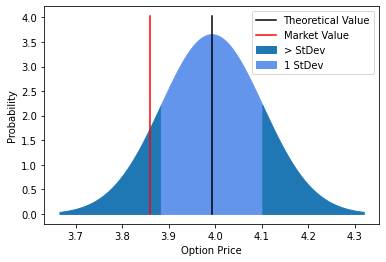

In [ ]:
x1 = np.linspace(C0-3*SE, C0-1*SE, 100)
x2 = np.linspace(C0-1*SE, C0+1*SE, 100)
x3 = np.linspace(C0+1*SE, C0+3*SE, 100)

s1 = stats.norm.pdf(x1, C0, SE)
s2 = stats.norm.pdf(x2, C0, SE)
s3 = stats.norm.pdf(x3, C0, SE)

plt.fill_between(x1, s1, color='tab:blue',label='> StDev')
plt.fill_between(x2, s2, color='cornflowerblue',label='1 StDev')
plt.fill_between(x3, s3, color='tab:blue')

plt.plot([C0,C0],[0, max(s2)*1.1], 'k',
        label='Theoretical Value')
plt.plot([market_value,market_value],[0, max(s2)*1.1], 'r',
        label='Market Value')

plt.ylabel("Probability")
plt.xlabel("Option Price")
plt.legend()
plt.show()